# Timeseries uncertainty demo

In this notebook we use the backend API to retrieve a time series and then plot it with the respective uncertainty bounds.

In [1]:
%matplotlib widget

import httpx
import matplotlib.pyplot as plt
import pandas as pd

coverage_identifier = "tas_seasonal_absolute_model_ensemble-rcp26-DJF"
point_coords = "POINT(11.5469 44.9524)"
date_range = "../.."
api_url = f"http://webapp:5001/api/v2/coverages/time-series/{coverage_identifier}"


def _parse_to_dataframe(time_series: dict):
    df = pd.DataFrame.from_records(time_series["values"])
    df["datetime"] = pd.to_datetime(df["datetime"])
    df.set_index("datetime", inplace=True)
    return df    

In [4]:
raw_response = httpx.get(
    api_url,
    params={
        "coords": point_coords,
        "datetime": date_range,
        "include_coverage_data": True,
        "include_observation_data": False,
        "coverage_data_smoothing": [
            "MOVING_AVERAGE_11_YEARS",
        ],
        "include_coverage_uncertainty": True,
        "include_coverage_related_data": False,
    }
)
raw_response.raise_for_status()

raw_series = raw_response.json()["series"]

series = {s["name"]: s for s in raw_series}
dfs = {v["name"]: _parse_to_dataframe(v) for v in series.values()}

In [5]:
smoothed_ma11_coverage_df = dfs[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"]
smoothed_ma11_uncertainty_lower_coverage_df = dfs[f"{coverage_identifier}__UNCERTAINTY_LOWER_BOUND__MOVING_AVERAGE_11_YEARS"]
smoothed_ma11_uncertainty_upper_coverage_df = dfs[f"{coverage_identifier}__UNCERTAINTY_UPPER_BOUND__MOVING_AVERAGE_11_YEARS"]

### Plotting

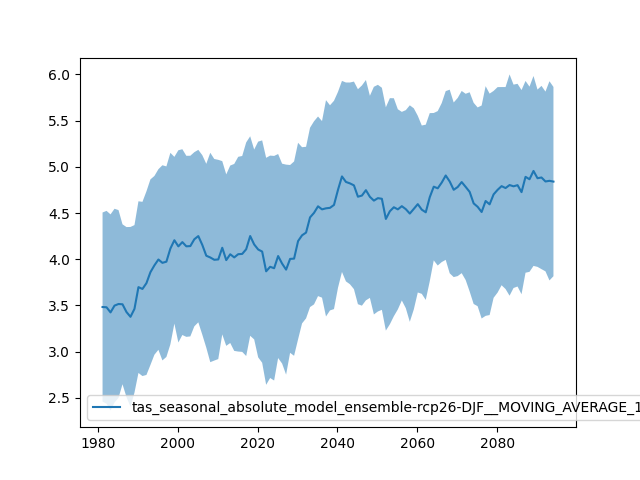

In [6]:
fig, ax = plt.subplots()
smoothed_ma11_tas_line, = ax.plot(smoothed_ma11_coverage_df, label=series[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"]["name"])
ax.fill_between(
    smoothed_ma11_uncertainty_lower_coverage_df.index, 
    smoothed_ma11_uncertainty_lower_coverage_df.value, 
    smoothed_ma11_uncertainty_upper_coverage_df.value,
    alpha=0.5,
    linewidth=0
)
ax.legend()

In [42]:
ax.clear()